# Week 10 Exercises

**Solutions for the exercises**

In this exercise we will study the $k$-means task. Recall that, given an input dataset $\mathbf{X}$ and a set of centers $\mathbf{C}$, the $k$-means cost function is defined as $$L(\mathbf{X}, \mathbf{C}) = \sum_{x \in \mathbf{X}} \min_{c \in \mathbf{C}} ||x - c||^2.$$

We'll start with some theoretical exercises.

# Ex1: k-Means

1. Given a set of points $\mathbf{X} \in \mathbb{R}^{n \times d}$ and a set of centers $\mathbf{C} \in \mathbb{R}^{k \times d}$, we can define an assignment matrix $\mathbf{A} \in \mathbb{R}^{n \times k}$. This matrix is 1 at $i, j$ if $x_i$ is closest to center $c_j$ and 0 otherwise. Suppose we take a step of Lloyd's algorithm and $\mathbf{A}$ does not change. What can you say about the loss value if we keep doing iterations of Lloyd's algorithm? 
2. Assume $k > n$. Initialize $\mathbf{C}$ such that, for every point $x_i$, there exists a center $c_j$ that only has $x_i$ assigned to it. Prove that Lloyd's algorithm on this $\mathbf{X}$ and $\mathbf{C}$ will always converge to 0 cost.

For the next questions, assume that $k=3$ and we are given $\mathbf{X} \in \mathbb{R}^{5 \times 2} = \{(b, 0), (0, b), (0, 0), (-1, 0), (0, -1)\}$, for $b \gg 1$ (read: "$b$ much bigger than $1$").

3. What is the smallest loss that can be obtained?
4. What is the largest loss value that Lloyd's algorithm may converge to?
5. Can you give an initialization that would lead to this?
6. Use the counterexample from above and argue that $k$-means++ should avoid the worst-case result of Lloyd's algorithm with random initialization.


### BEGIN SOLUTION MATH

1. It remains fixed.

2. After the first round, for every point $x_i$, the cluster center $c_j$ that has only $x_i$ assigned to it will be replaced by the mean of the single point $x_i$ and thus will end on top of $x_i$. The cost is then $0$.

3. Your optimal clustering is to put one center on $(b, 0)$, one on $(0, b)$, and the remaining one between $(0, 0), (-1, 0)$ and $(0, -1)$.

4. The worst clustering that Lloyd's can converge to is to have one center serving both the $(0, b)$ and $(b, 0)$ points. 

5. This would occur if, for example, your initialization started with the three centers at $(0, 0), (-1, 0)$ and $(0, -1)$. Then the center at $(0, 0)$ would be closest to both the points at $(0, b)$ and $(b, 0)$ and would end up accounting for both of those outliers.

6. 
### END SOLUTION MATH


### Looking forward

We will investigate variants of questions 4-7 through the rest of this exercise set. To do this, we will design two datasets -- one that is reasonable for Lloyd's algorithm and one that we expect will break Lloyd's algorithm. We will then see whether $k$-means++ can 'fix' Lloyd's algorithm on the 'bad' dataset.

We start by defining some helper functions:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a random $k$-Means solution by sampling randomly from the input dataset.
def init_random(x, k):
    d = int(x.shape[1])
    random_samples = np.random.choice(len(x), k)
    return x[random_samples]

# Calculate the Euclidean distance between points a and b
def euc_dist(a, b):
    return np.sqrt(np.sum(np.square(a - b)))

In [3]:
#Plotting function
def plot_lloyds(x, all_centers=None):
    plt.scatter(x[:, 0], x[:, 1], alpha=0.8, s=10)
    if all_centers:
        colors = plt.get_cmap('Reds')(np.linspace(0, 1, len(all_centers)))
        for i, centers in enumerate(all_centers):
            if i == len(all_centers) - 1:
                m = '*'
            else:
                m = '.'
            if i > 0:
                for j in range(len(centers)):
                    plt.plot(
                        [centers[j][0], all_centers[i-1][j][0]],
                        [centers[j][1], all_centers[i-1][j][1]],
                        linewidth=1,
                        marker=m,
                        markersize=15 * (i+1)/len(all_centers),
                        color=colors[i],
                        markeredgecolor=colors[i],
                    )
    plt.show()

# Dataset descriptions:
We now define the datasets that we will be working with in this exercise. The first is an artificially bad dataset that is designed to 'break' Lloyd's algorithm with naive initialization. $\frac{1}{3}$ of the clusters in the bad dataset have many points while the remaining $\frac{2}{3}$ of the clusters have one point each. Consider that we can set these clusters as far apart as we want.

The second dataset is a 'well-clusterable' dataset. It is designed to have nice clusters that are easy to find. We expect that Lloyd's algorithm will perform reasonably well on this dataset.

In [4]:
np.random.seed(1234)
def create_artificial_bad_dataset(n, k=15, vert_spacing=100, horiz_spacing=None):
    """
    Create a dataset of k clusters where 1/3 of the clusters have many points.
    The other clusters each have size 1 point.
    All clusters have small variance, so they are 'tightly packed'.
    Lloyd's algorithm should perform arbitrarily poorly on this dataset.
    """
    if k % 3 != 0:
        raise ValueError("Artificial bad dataset needs k to be divisible by 3")
    if horiz_spacing is None:
        horiz_spacing = 6 * vert_spacing / k
    
    # assume dimensionality is 2 so it's easy to plot
    points = np.zeros((n, 2))
    for column in range(int(k/3)):
        x = horiz_spacing * column
        points[int(column * 3 * n / k)] = [column * horiz_spacing, vert_spacing]
        points[int((column+1) * 3 * n / k - 1)] = [column * horiz_spacing, -vert_spacing]
        points[int(column * 3 * n / k + 1) : int((column+1) * 3 * n / k - 1)] = np.random.multivariate_normal([column * horiz_spacing, 0], [[1, 0], [0, 1]], [int(3 * n / k - 2)]) 
        
    return points

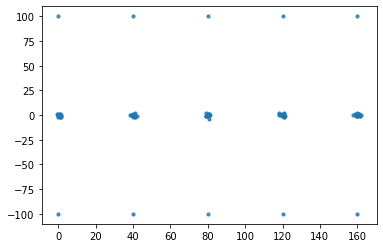

In [5]:
# Plot the artificially bad dataset
artificial_bad_x = create_artificial_bad_dataset(100)
plot_lloyds(artificial_bad_x)

In [6]:
np.random.seed(1234)
def create_hierarchical_clusters(n, point=None, std_dev=100, d=2, recur_likelihood=1.0):
    """
    Create a dataset that samples from a Gaussian distribution.
    For each sample, recursively sample points from its neighborhood with some likelihood.
    In expectation, this creates a normally distributed ball of Gaussian clusters
        such that each cluster likely has sub-clusters within it.
    """
    if point is None:
        point = np.zeros(d)
    if n <= 1:
        return np.random.multivariate_normal(point, np.eye(d) * std_dev, 1)
    
    points = []
    points_remaining = n
    i = 0
    while points_remaining > 1:
        subcluster_size = int(np.random.uniform() * points_remaining)
        if np.random.uniform() < recur_likelihood:
            subcluster_mean = np.random.multivariate_normal(point, np.eye(d) * std_dev)
            subcluster = create_hierarchical_clusters(
                n=subcluster_size,
                point=subcluster_mean,
                std_dev=std_dev/10,
                d=d,
                recur_likelihood=recur_likelihood * np.random.uniform()
            )
        else:
            subcluster = np.random.multivariate_normal(point, np.eye(d) * std_dev, subcluster_size)
        points.append(subcluster)
        points_remaining -= subcluster_size
            
    if points:
        points = np.concatenate(points, axis=0)
        if len(points) > n:
            points = points[np.random.choice(len(points), n)]
        return points
    return np.empty([0, d])

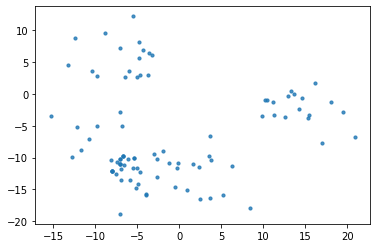

In [7]:
well_clusterable_x = create_hierarchical_clusters(100, d=2)
plot_lloyds(well_clusterable_x)

# Lloyd's Algorithm
We will now implement Lloyd's algorithm. This will be done in several sub-methods that we implement first:

In [8]:
def get_assignments(points, centers):
    '''
    Return a vector of length n where the i-th value says which center x_i is assigned to.
    For example, if the first point is closest to the fifth center, then assignments[0] = 4.
    '''
    assignments = -1 * np.ones(len(points))
    
    # Tip: we defined a function for the euclidean distance in the first cell of this notebook.
    ### YOUR CODE HERE
    for i, point in enumerate(points):
        min_dist = np.inf
        closest_center = None
        for j, center in enumerate(centers):
            point_center_dist = euc_dist(point, center)
            if point_center_dist < min_dist:
                min_dist = point_center_dist
                closest_center = j
        assignments[i] = closest_center
    ### END CODE

    return assignments.astype(np.int32)

def score(points, centers):
    '''
    Given points and centers, return the total cost of the kmeans objective
    '''
    assignments = get_assignments(points, centers)
    cost = 0
    
    ### YOUR CODE HERE
    for i, point in enumerate(points):
        cost += np.square(euc_dist(point, centers[assignments[i]]))
    ### END CODE
    
    return cost

def lloyds_step(points, centers):
    '''
    Given the points and centers, get the new set of centers.
    This means that we:
        1. Find which points are closest to each center using the get_assignments() method above
        2. Find the mean of each cluster
        3. Update each center to the mean of its cluster
    '''
    n, d = points.shape
    k = centers.shape[0]
    assignments = get_assignments(points, centers)
    new_centers = np.zeros((k, d))
    
    # Assign new centers to the means of the clusters
    # Tip: consider using np.where(assignments == c) to find the indices of the points that belong to center c
    #                                                for 0 <= c < k
    ### YOUR CODE HERE
    for c in range(len(centers)):
        point_inds = np.where(assignments == c)
        new_centers[c] = np.mean(points[point_inds], axis=0)
    ### END CODE
        
    return new_centers


We now put these methods together into Lloyd's algorithm:

In [9]:
def lloyds(x, k, init, tol=1e-8, max_steps=1000, loud=True):
    all_centers = [init(x, k)]
    step = 0
    cost = score(x, all_centers[-1])
    loss_change = np.inf
    while loss_change > tol and step < max_steps:
        # Do a step of Lloyd's algorithm and evaluate our new loss
        new_centers = lloyds_step(x, all_centers[-1])
        new_cost = score(x, new_centers)
        loss_change = cost - new_cost
        cost = new_cost
        
        step += 1
        all_centers.append(new_centers)
        if loud:
            print(cost)
        
    return all_centers

### Visualization Description:
When plotting Lloyd's algorithm, we represent the final set of centers with stars. We then use a streak of red lines to show how the centers moved. The printed values are the loss values at each step.

1351.2564559310358
822.1930789745581
802.6873582339374
768.2118373052051
762.7310638422713
760.2665321006123
760.2665321006123


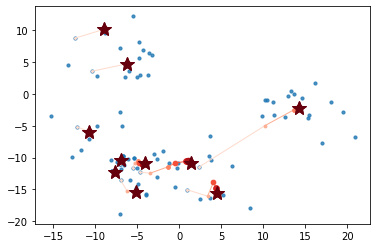

In [10]:
all_centers = lloyds(well_clusterable_x, 10, init_random)
plot_lloyds(well_clusterable_x, all_centers)

c:\Users\au587694\Anaconda3\envs\ML\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\au587694\Anaconda3\envs\ML\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


69758.50828850485
6258.203700498128
4956.330768068694
4956.330768068694


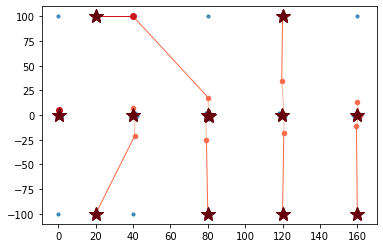

In [11]:
k = 15
all_centers = lloyds(artificial_bad_x, k, init_random)
plot_lloyds(artificial_bad_x, all_centers)

# $k$-Means++
Next, we will implement $k$-means++. Recall that $k$-means++ initializes center $c_i$ based on the distances of the points to centers $c_1$ through $c_{i-1}$. More specifically, given a set of points $\mathbf{X}$ and a set of $l$ centers $\mathbf{C}$, we define a probability distribution:
$$ p(x_i) = \frac{\min_{c \in \mathbf{C}} ||x_i - c||^2}{\sum_{x \in \mathbf{X}} \min_{c \in \mathbf{C}} ||x - c||^2}. $$

We then sample the next center from the set of points based on this probability distribution. The first center is chosen uniformly at random from $\mathbf{X}$.

## Questions:
- Is a point ever going to get sampled twice?
- Suppose there are $n-2$ points at the origin, one point at (0, 1) and another at (1, 0). How many steps of Lloyd's algoirthm are required to guarantee 0 loss if we use $k$-means++ initialization with $k=3$?

### BEGIN SOLUTION MATH
- If a point has already been sampled, its cost in the solution up to now is $0$. Thus the sampling probability of the point becomes $0$ and it will never be sampled again.

- 0 steps of Lloyd's algorithm are required. Each of the three clusters will be hit perfectly during sampling.
### END SOLUTION MATH

In [12]:
def get_min_dists_to_centers(points, new_center, dists):
    '''
    Return distances of points to centers given a new center.
    
    If the i-th point has distance 10 to its closest center, then dists[i] = 10.
    
    Since we are given the distances of the points to the old centers, we are simply interested in which
        points are closest to the new center and updating the dists accordingly.
    '''
    if dists is None:
        # dists = None when we had no centers before. Distance to closest center is then inf
        dists = np.ones((len(points))) * np.inf
    if len(new_center.shape) == 1:
        new_center = np.expand_dims(new_center, axis=0)
        
    ### YOUR CODE HERE
    new_dists = np.sum((points - new_center) ** 2, axis=-1)
    improved_inds = new_dists < dists
    dists[improved_inds] = new_dists[improved_inds]
    ### END CODE
    
    return dists

def init_kmeans_plusplus(points, k):
    '''
    Initialize a set of k centers using k-means++
    '''
    n, d = int(points.shape[0]), int(points.shape[1])
    # np.random.choice(n, p) selects from n items according to probability distribution p
    centers = [np.random.choice(n)]
    sq_dists = None
    
    ### YOUR CODE HERE
    for i in range(k-1):
        sq_dists = get_min_dists_to_centers(points, points[np.array(centers)[-1]], sq_dists)
        prob_dist = sq_dists / np.sum(sq_dists)
        centers.append(np.random.choice(n, p=prob_dist))
    ### END CODE
    
    return points[centers]

## Comparing $k$-Means++ and Random Initialization

We now compare the results of $k$-means++ and random initialization with Lloyd's algorithm.

### Well-Clusterable Data
We start with plots on the well-clusterable data. The printed values are the loss values during each step of Lloyd's algorithm.

978.161376405262
940.0838314354409
906.3409322275478
888.6398997565033
881.3010464966615
881.3010464966615


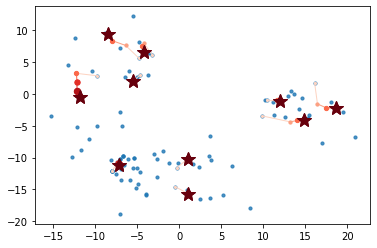

793.9421386607588
767.7411031144392
759.1382545515688
759.1382545515688


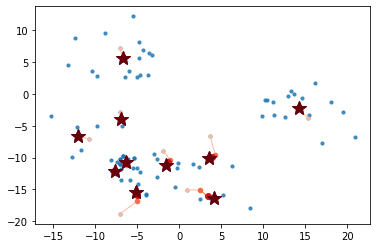

In [13]:
all_centers = lloyds(well_clusterable_x, 10, init_random)
plot_lloyds(well_clusterable_x, all_centers)

all_centers = lloyds(well_clusterable_x, 10, init_kmeans_plusplus)
plot_lloyds(well_clusterable_x, all_centers)

### Artificially bad data
Now we compare Lloyd's algorithm with $k$-means++ vs. random initialization on the artificially bad dataset. Note the loss values at the end of Lloyd's convergence.

36975.67381385021
10140.237445201285
8139.765025650638
8139.765025650638


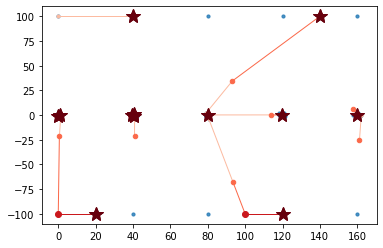

165.6050779629256
165.6050779629256


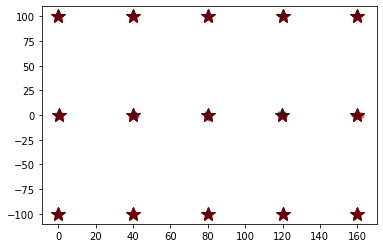

In [17]:
all_centers = lloyds(artificial_bad_x, 15, init_random)
plot_lloyds(artificial_bad_x, all_centers)

all_centers = lloyds(artificial_bad_x, 15, init_kmeans_plusplus)
plot_lloyds(artificial_bad_x, all_centers)

## Ex2: PCA on MNIST Digits
In this exercise we will experiment with PCA on digits.

1. Run PCA on the training data train_dat http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html (use n_components = 784) and use ``plot_images`` to plot the 20 directions with largest variance. Use this PCA model for all subsequent computations. The directions can be found with the attribute ``components_``.
2. Take the first 20 data points from the training data and project them onto the first $k$ components for $k \in \{1, 2,4,8,16, 32, 64\}$. Then plot them as images. What do you see?
    **Hint:** To project them compute the length of the projection of each point onto the first $k$ directions and then compute for each image compute the linear combination of the first $k$ directions given by these directions ($XZZ^\intercal$ as in lecture).
3. Map all the training data train_dat to 2D (the length of the projection on the first two directions) and make a scatter plot where you color with the label and see if there is some structure (use scatter with ``cmap = plt.cm.Paired``, like ``ax.scatter(x,y, c=lab, cmap=plt.cm.Paired)``)
4. Map all training data train_dat to $32$ dimensions and train an SGD Classifier. Observe the test accuracy of the classifier. How should you select target dimension in real life?
Use the following classifer (svm loss): ``clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200, fit_intercept=True)``

Discuss the results. Are they what you expect? Why? Why not.

First 20 directions (eigenvectors X^T X)


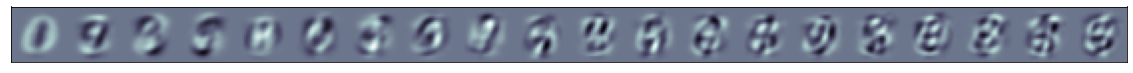

Original images:


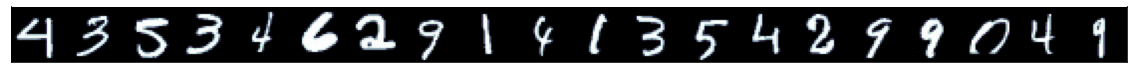

1: compression visualization
Z shape (784, 1)
pimgs shape (20, 784)


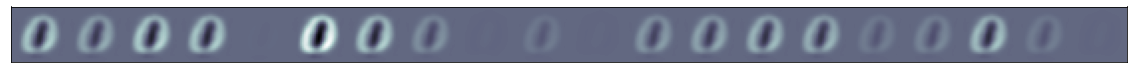

2: compression visualization
Z shape (784, 2)
pimgs shape (20, 784)


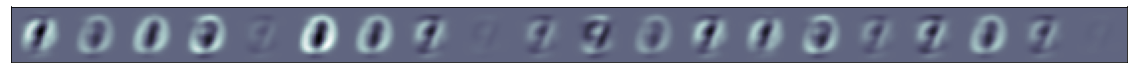

4: compression visualization
Z shape (784, 4)
pimgs shape (20, 784)


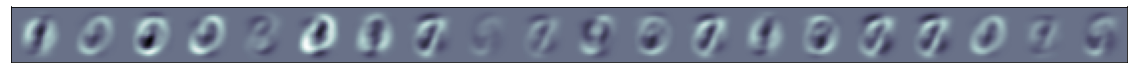

8: compression visualization
Z shape (784, 8)
pimgs shape (20, 784)


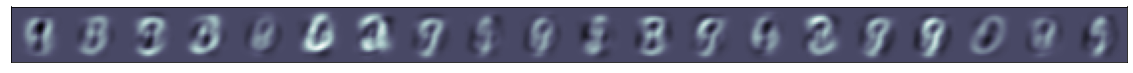

16: compression visualization
Z shape (784, 16)
pimgs shape (20, 784)


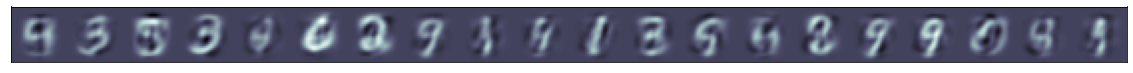

32: compression visualization
Z shape (784, 32)
pimgs shape (20, 784)


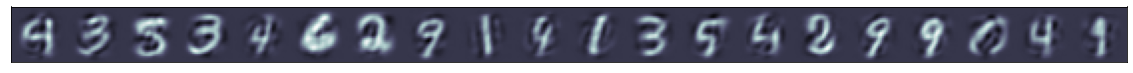

64: compression visualization
Z shape (784, 64)
pimgs shape (20, 784)


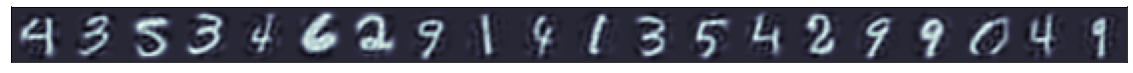

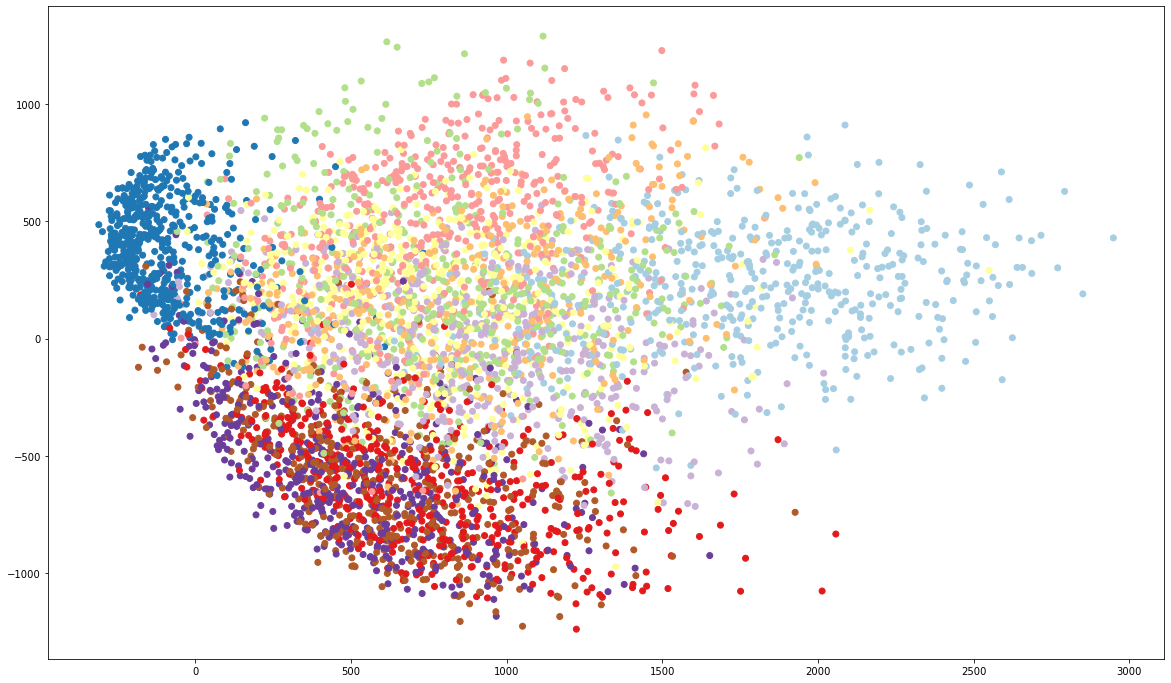

Test Accuracy of 32 Dim PCA: 81.3
Test Accuracy original: 84.2


In [15]:
# ## PCA on digits
# In this exercise we will experiment with PCA on digits.

# 1. Run PCA on the training data train_dat http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html (use n_components = 784) and use ``plot_images`` to plot the 20 directions with largest variance. Use this PCA model for all subsequent computations. The directions can be found with the attribute ``components_``.
# 2. Take the first 20 data points from the training data and project them onto the first $k$ components for $k \in \{1, 2,4,8,16, 32, 64\}$. Then plot them as images. What do you see?
#     **Hint:** To project them compute the length of the projection of each point onto the first $k$ directions and then compute for each image compute the linear combination of the first $k$ directions given by these directions (XZZ^T as in lecture).
# 3. Map all the training data train_dat to 2D (the length of the projection on the first two directions) and make a scatter plot where you color with the label and see if there is some structure (use scatter with ``cmap = plt.cm.Paired``, like ``ax.scatter(x,y, c=lab, cmap=plt.cm.Paired)``)
# 4. Map all training data train_dat to $32$ dimensions and train an SGD Classifier. Observe the test accuracy of the classifier. How should you select target dimension in real life?
#    Use the following classifer (svm loss): ``clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200, fit_intercept=True)``

# Discuss the results. Are they what you expect? Why? Why not.


# %matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
import torchvision.datasets as datasets

# Load full dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)



def plot_images(dat, k=20, size=28):
    """ Plot the first k vectors as 28 x 28 images """
    x2 = dat[0:k,:].reshape(-1, size, size)
    x2 = x2.transpose(1, 0, 2)
    fig, ax = plt.subplots(figsize=(20,12))
    ax.imshow(x2.reshape(size, -1), cmap='bone')
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()

#data, labels =
data = mnist_trainset.data.numpy().reshape((60000, 28*28))
labels = mnist_trainset.targets.numpy()

# reduce size for speed
rp = np.random.permutation(len(labels))
train_dat = data[rp[:5000],:]
test_dat = data[rp[5000:6000], :]
train_lab = labels[rp[:5000]]
test_lab = labels[rp[5000:6000]]

components = None
## TASK 1
### YOUR CODE HERE
pca = PCA(n_components=784)
pca.fit(train_dat)
components = pca.components_
### END CODE
print('First 20 directions (eigenvectors X^T X)')
plot_images(components, 20)

## TASK 2
# take the first 20 data point and project them onto the first k components and plot for k in [1, 2,4,8,16, 32, 64]
img = train_dat[0:20, :]
print('Original images:')
plot_images(img, 20)
for k in [1, 2, 4, 8, 16, 32, 64]:
    ### YOUR CODE HERE
    print('{0}: compression visualization'.format(k))
    Z = components[0:k].T
    print('Z shape', Z.shape)
    proj_imgs = img @ Z @ Z.T
    print('pimgs shape', proj_imgs.shape)
    plot_images(proj_imgs)
    ### END CODE
    
# map the data to 2D and plot the results colored by label
proj = None
## TASK 3
### YOUR CODE HERE
proj = train_dat @ components[0:2].T
### END CODE
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(proj[:,0], proj[:,1], c=train_lab, cmap=plt.cm.Paired)
plt.show()

## TASK 4
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200, fit_intercept=True)
### YOUR CODE HERE
proj_train_dat = train_dat @ components[0:32].T
clf.fit(proj_train_dat, train_lab)
### END CODE

clf_original = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200, fit_intercept=True)
clf_original.fit(train_dat, train_lab)

proj_test_dat = test_dat @ components[0:32].T
acc = (clf.predict(proj_test_dat) == test_lab).mean()
print('Test Accuracy of 32 Dim PCA:', 100*acc)
print('Test Accuracy original:',100*((clf_original.predict(test_dat) == test_lab).mean()))